In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '38-resnet152'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_PATH = f'{COLAB_BASE_PATH}Submissions/{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = f'{COLAB_BASE_PATH}Submissions/{MODEL_NAME}_last.csv'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
# !pip install --quiet efficientnet
!pip install --quiet image-classifiers

In [5]:
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
# import efficientnet.tfkeras as efn
from classification_models.tfkeras import Classifiers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## TPU configuration

In [6]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.14.193.66:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.14.193.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.14.193.66:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# Model parameters

In [31]:
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 512,
  "EPOCHS": 40,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 3,
  "BASE_MODEL": 'resnet152',
  "BASE_MODEL_WEIGHTS": 'imagenet11k',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'resnet152',
 'BASE_MODEL_WEIGHTS': 'imagenet11k',
 'BATCH_SIZE': 512,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 40,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.0003,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 3,
 'WIDTH': 256}

# Load data

In [32]:
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-c2f318ab381f072971d2adb35fbd1cf6f734c11ee731b63b7915ac3e'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [33]:
#@title
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

## Auxiliary functions

In [34]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = 45. * tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1] ,dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0), [3, 3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM, 3])

## Learning rate scheduler

Learning rate schedule: 0 to 0.000293 to 4.36e-05


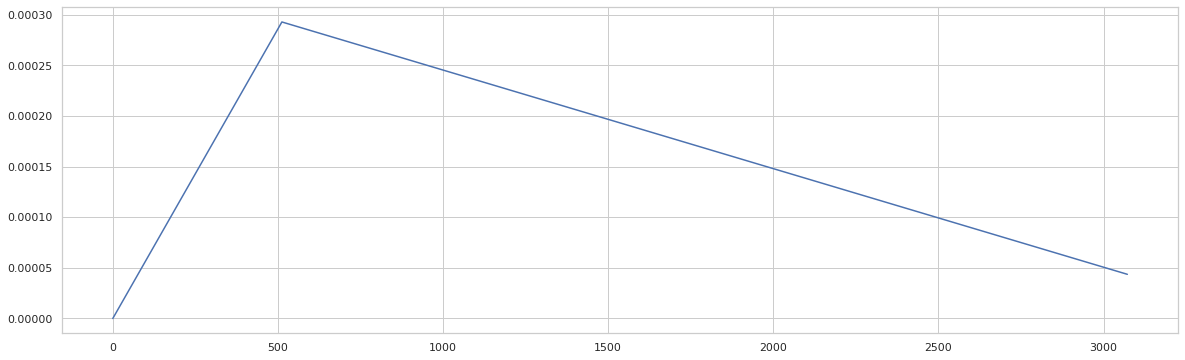

In [35]:
lr_min = 1e-6
lr_start = 0
lr_max = config['LEARNING_RATE']
step_size = 45365 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
hold_max_steps = 0
warmup_steps = step_size * 5

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [linear_schedule_with_warmup(tf.cast(x, tf.float32), total_steps=total_steps, 
                                 warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                                 lr_start=lr_start, lr_max=lr_max, lr_min=lr_min) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [36]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    BaseModel, preprocess_input = Classifiers.get(config['BASE_MODEL'])
    base_model = BaseModel(input_shape=input_shape, 
                           weights=config['BASE_MODEL_WEIGHTS'], 
                           include_top=False)

    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    output = L.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [37]:
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)

history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        train_size = count_data_items(train_filenames)

        step_size = train_size // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: linear_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                     total_steps=total_steps, warmup_steps=warmup_steps, 
                                                     hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                     lr_max=lr_max, lr_min=lr_min)

            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=step_size,
                            callbacks=[checkpoint, es], 
                            verbose=2).history

        # save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        history_list.append(history)

        # Make predictions (last model)
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)

        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)

        # Make predictions (best model)
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds[x['image_name']], axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.14.193.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.14.193.66:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/40
93/93 - 97s - loss: 0.6212 - auc: 0.7329 - val_loss: 7.8949 - val_auc: 0.5000
Epoch 2/40
93/93 - 75s - loss: 0.2652 - auc: 0.8955 - val_loss: 1.2300 - val_auc: 0.5084
Epoch 3/40
93/93 - 67s - loss: 0.2605 - auc: 0.9032 - val_loss: 1.6216 - val_auc: 0.5005
Epoch 4/40
93/93 - 75s - loss: 0.2515 - auc: 0.9166 - val_loss: 0.4928 - val_auc: 0.5294
Epoch 5/40
93/93 - 68s - loss: 0.2504 - auc: 0.9183 - val_loss: 0.5267 - val_auc: 0.5445
Epoch 6/40
93/93 - 75s - loss: 0.2432 - auc: 0.9267 - val_loss: 0.4506 - val_auc: 0.4194
Epoch 7/40
93/93 - 68s - loss: 0.2379 - auc: 0.9329 - val_loss: 0.5249 - val_auc: 0.5290
Epoch 8/40
93/93 - 68s - loss: 0.2323 - auc: 0.9394 - val_loss: 0.5087 - val_auc: 0.5713
Epoch 9/40
93/93 - 75s - loss: 0.2290 - auc: 0.9430 - val_loss: 0.3904 - val_auc: 0.7794
Epoch 10/40
93/93 - 68s - loss: 0.2252 - auc: 0.9473 - val_loss: 0.5751 - val_auc: 0.6595
Epoch 11/40
93/93 - 75s - loss: 0.2245 - auc: 0.9468 - val_loss: 0.3211 - val_auc: 0.8208
Epoch 12/40
93/93 -

INFO:tensorflow:Initializing the TPU system: grpc://10.14.193.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.14.193.66:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/40
93/93 - 95s - loss: 0.3856 - auc: 0.7778 - val_loss: 2.5030 - val_auc: 0.5518
Epoch 2/40
93/93 - 74s - loss: 0.2612 - auc: 0.9001 - val_loss: 0.5552 - val_auc: 0.5453
Epoch 3/40
93/93 - 74s - loss: 0.2548 - auc: 0.9114 - val_loss: 0.3830 - val_auc: 0.4306
Epoch 4/40
93/93 - 68s - loss: 0.2499 - auc: 0.9202 - val_loss: 0.4855 - val_auc: 0.4525
Epoch 5/40
93/93 - 68s - loss: 0.2491 - auc: 0.9204 - val_loss: 0.5209 - val_auc: 0.5317
Epoch 6/40
93/93 - 68s - loss: 0.2433 - auc: 0.9257 - val_loss: 0.3881 - val_auc: 0.4814
Epoch 7/40
93/93 - 68s - loss: 0.2395 - auc: 0.9306 - val_loss: 0.5344 - val_auc: 0.5088
Epoch 8/40
93/93 - 74s - loss: 0.2362 - auc: 0.9350 - val_loss: 0.3680 - val_auc: 0.6541
Epoch 9/40
93/93 - 68s - loss: 0.2321 - auc: 0.9378 - val_loss: 0.3738 - val_auc: 0.6595
Epoch 10/40
93/93 - 68s - loss: 0.2284 - auc: 0.9438 - val_loss: 0.3791 - val_auc: 0.7587
Epoch 11/40
93/93 - 74s - loss: 0.2267 - auc: 0.9440 - val_loss: 0.3207 - val_auc: 0.8222
Epoch 12/40
93/93 -

INFO:tensorflow:Initializing the TPU system: grpc://10.14.193.66:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.14.193.66:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/40
97/97 - 101s - loss: 0.3733 - auc: 0.7838 - val_loss: 0.8057 - val_auc: 0.5451
Epoch 2/40
97/97 - 77s - loss: 0.2634 - auc: 0.8966 - val_loss: 0.3744 - val_auc: 0.5087
Epoch 3/40
97/97 - 77s - loss: 0.2550 - auc: 0.9092 - val_loss: 0.3687 - val_auc: 0.6135
Epoch 4/40
97/97 - 71s - loss: 0.2494 - auc: 0.9189 - val_loss: 0.4666 - val_auc: 0.5075
Epoch 5/40
97/97 - 71s - loss: 0.2468 - auc: 0.9199 - val_loss: 0.6358 - val_auc: 0.5263
Epoch 6/40
97/97 - 78s - loss: 0.2422 - auc: 0.9269 - val_loss: 0.3478 - val_auc: 0.6836
Epoch 7/40
97/97 - 71s - loss: 0.2384 - auc: 0.9327 - val_loss: 0.3805 - val_auc: 0.5422
Epoch 8/40
97/97 - 71s - loss: 0.2323 - auc: 0.9388 - val_loss: 0.4674 - val_auc: 0.6293
Epoch 9/40
97/97 - 71s - loss: 0.2301 - auc: 0.9409 - val_loss: 0.4309 - val_auc: 0.6414
Epoch 10/40
97/97 - 78s - loss: 0.2271 - auc: 0.9438 - val_loss: 0.3251 - val_auc: 0.7949
Epoch 11/40
97/97 - 84s - loss: 0.2249 - auc: 0.9465 - val_loss: 0.3003 - val_auc: 0.8322
Epoch 12/40
97/97 

## Model loss graph

Fold: 1


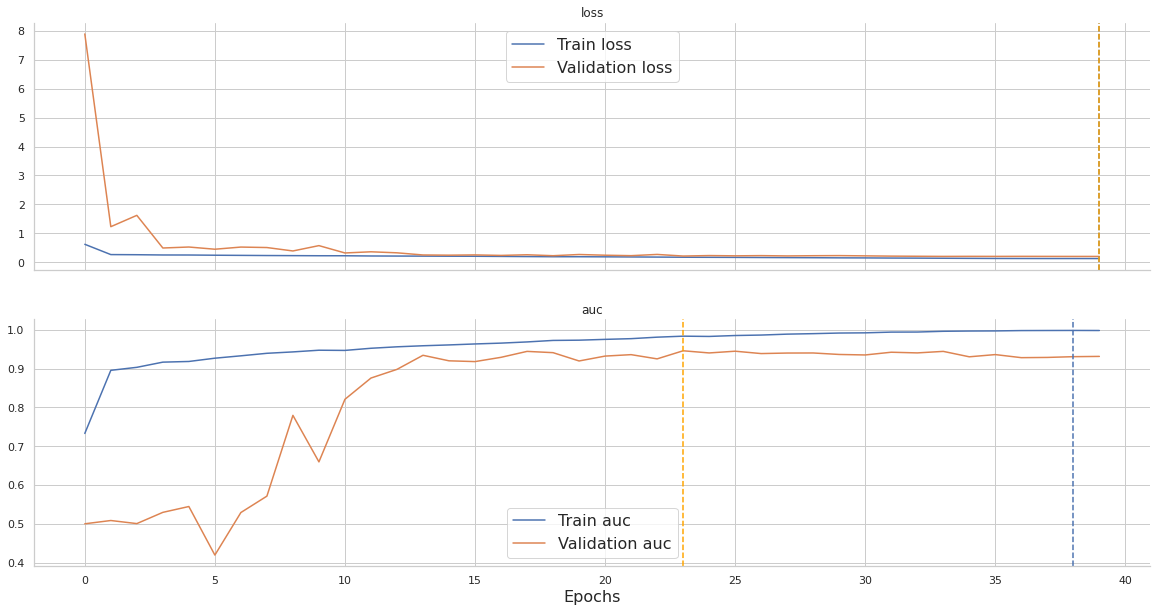

Fold: 2


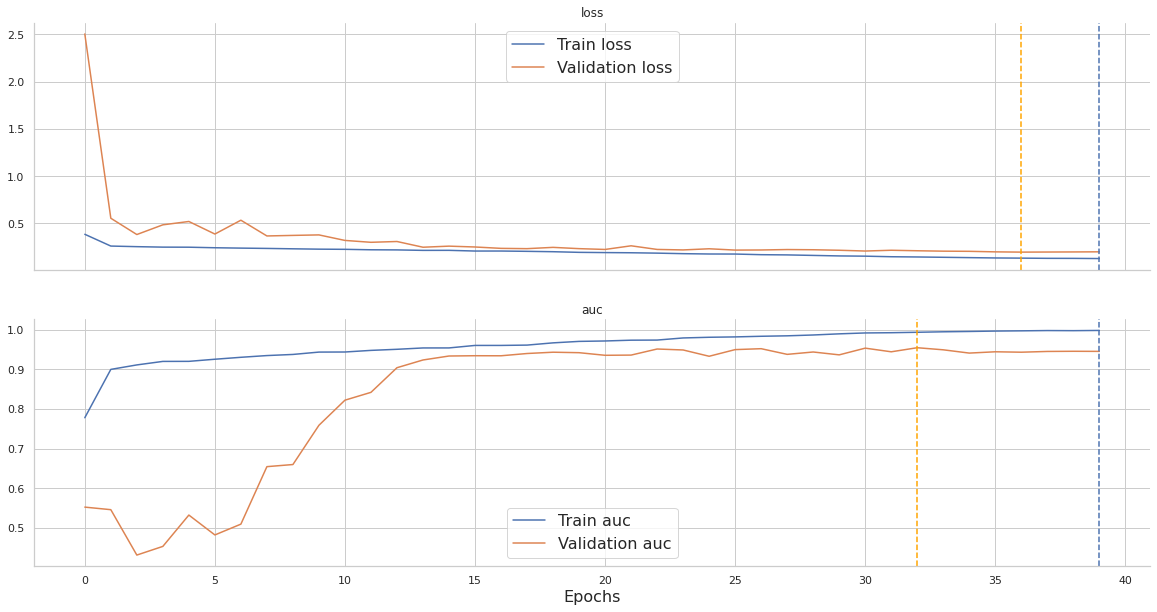

Fold: 3


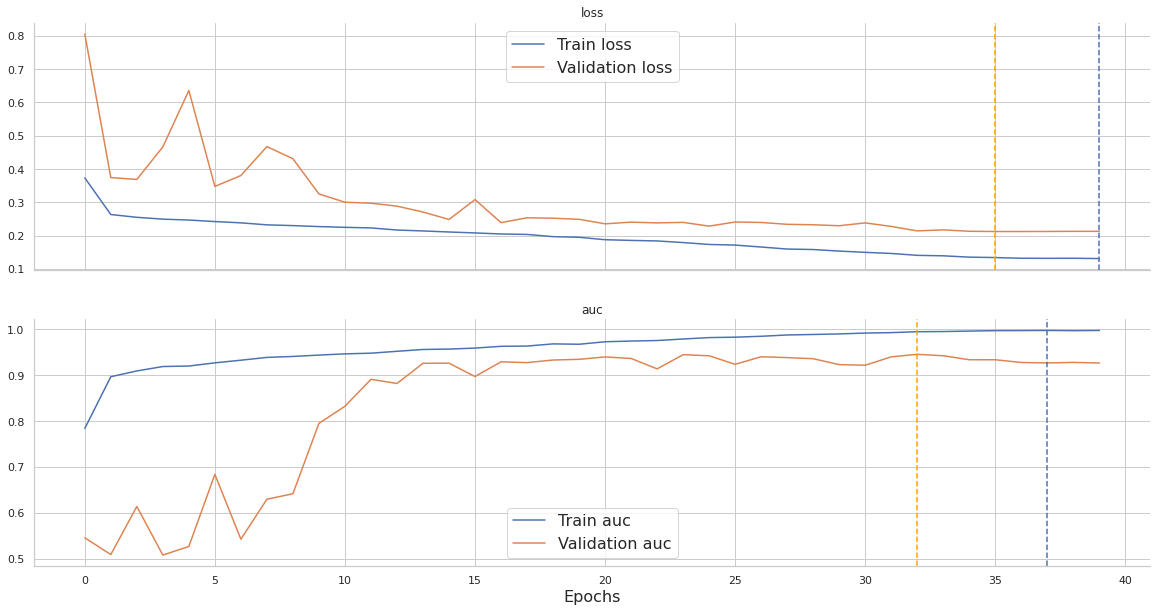

In [38]:
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

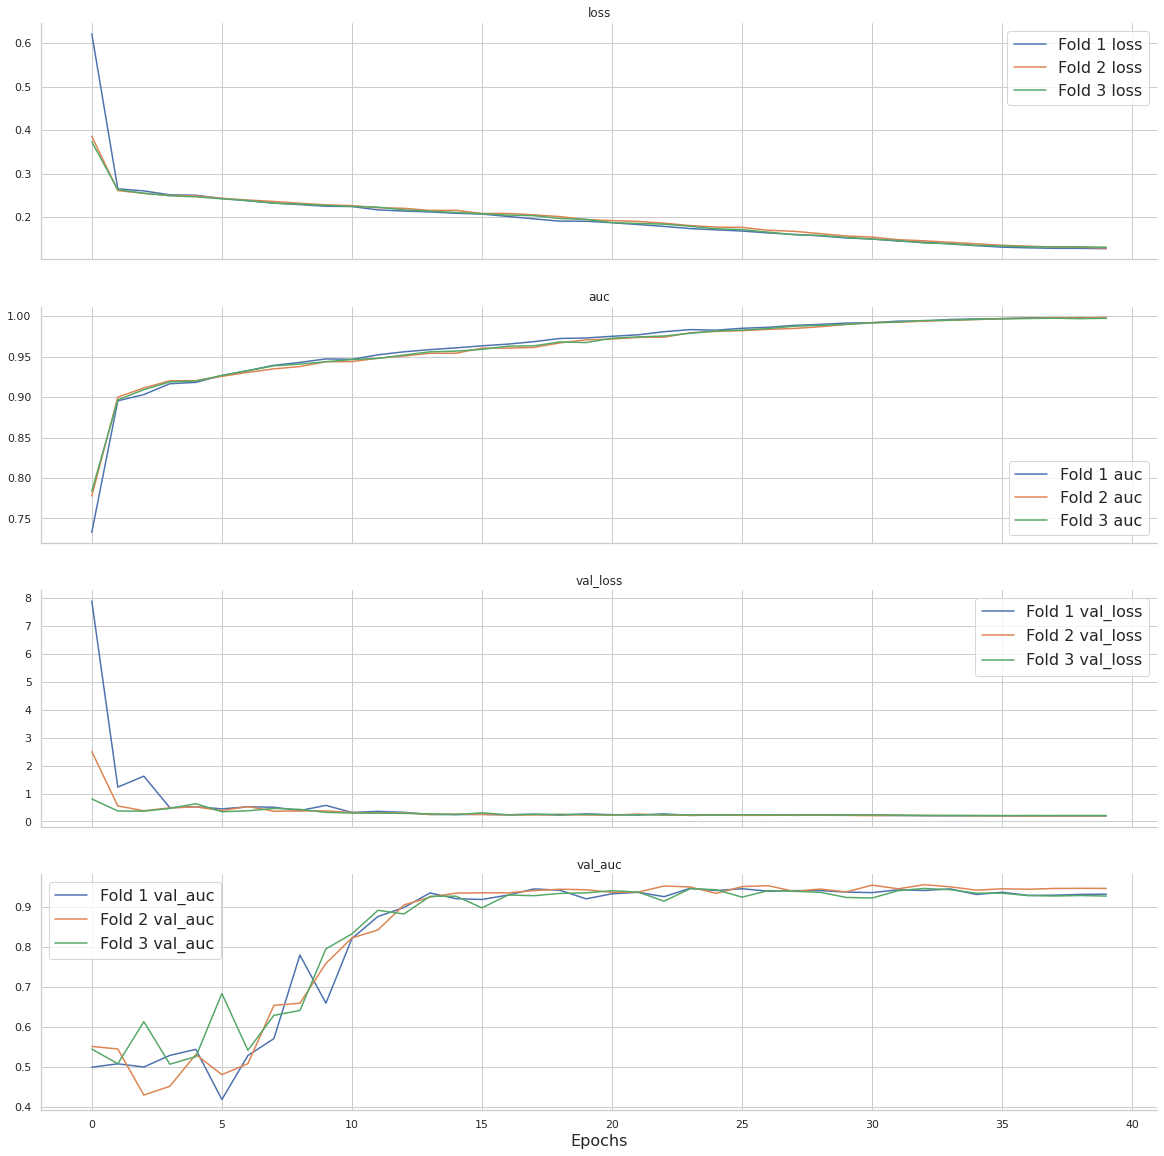

In [39]:
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [40]:
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.996839,0.765615,0.231224,0.996664,0.739665,0.997251,0.795499,0.996603,0.761682
Accuracy,0.998641,0.981763,0.016878,0.998939,0.983398,0.998747,0.981885,0.998237,0.980007
Precision,0.993131,0.474006,0.519124,0.995585,0.459016,0.995381,0.494253,0.988426,0.468750
Recall,0.928968,0.292433,0.636535,0.945493,0.261682,0.932900,0.352459,0.908511,0.263158
F1-score,0.959935,0.360632,0.599304,0.969892,0.333333,0.963128,0.411483,0.946785,0.337079
Support,469.666667,114.333333,355.333333,477.000000,107.000000,462.000000,122.000000,470.000000,114.000000


# Model evaluation by Subset

In [41]:
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.996839,0.765615,0.231224,0.996664,0.739665,0.997251,0.795499,0.996603,0.761682
male,0.998383,0.787313,0.211071,0.998640,0.774396,0.999015,0.815053,0.997495,0.772490
female,0.994393,0.723359,0.271035,0.993512,0.678710,0.994437,0.755378,0.995231,0.735988
head/neck,0.998545,0.762732,0.235813,0.999975,0.897180,0.996051,0.687263,0.999608,0.703754
upper extremity,0.995718,0.756817,0.238901,0.994405,0.810437,0.999965,0.687587,0.992784,0.772427
lower extremity,0.996934,0.767156,0.229778,0.992489,0.752173,0.999362,0.817295,0.998950,0.732001
torso,0.996647,0.782831,0.213816,0.998215,0.651264,0.995589,0.875912,0.996136,0.821316
0 <= age < 26,0.997407,0.621619,0.375788,0.995445,0.503261,1.000000,0.581967,0.996777,0.779630
26 <= age < 40,0.996203,0.768820,0.227382,0.999988,0.532825,0.991024,0.931359,0.997597,0.842278


# Model evaluation (best)

In [42]:
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric,,,,,,,,,
ROC AUC,0.996839,0.765615,0.231224,0.996664,0.739665,0.997251,0.795499,0.996603,0.761682
Accuracy,0.998641,0.981763,0.016878,0.998939,0.983398,0.998747,0.981885,0.998237,0.980007
Precision,0.993131,0.474006,0.519124,0.995585,0.459016,0.995381,0.494253,0.988426,0.468750
Recall,0.928968,0.292433,0.636535,0.945493,0.261682,0.932900,0.352459,0.908511,0.263158
F1-score,0.959935,0.360632,0.599304,0.969892,0.333333,0.963128,0.411483,0.946785,0.337079
Support,469.666667,114.333333,355.333333,477.000000,107.000000,462.000000,122.000000,470.000000,114.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Subset/ROC AUC,,,,,,,,,
Overall,0.996839,0.765615,0.231224,0.996664,0.739665,0.997251,0.795499,0.996603,0.761682
male,0.998383,0.787313,0.211071,0.998640,0.774396,0.999015,0.815053,0.997495,0.772490
female,0.994393,0.723359,0.271035,0.993512,0.678710,0.994437,0.755378,0.995231,0.735988
head/neck,0.998545,0.762732,0.235813,0.999975,0.897180,0.996051,0.687263,0.999608,0.703754
upper extremity,0.995718,0.756817,0.238901,0.994405,0.810437,0.999965,0.687587,0.992784,0.772427
lower extremity,0.996934,0.767156,0.229778,0.992489,0.752173,0.999362,0.817295,0.998950,0.732001
torso,0.996647,0.782831,0.213816,0.998215,0.651264,0.995589,0.875912,0.996136,0.821316
0 <= age < 26,0.997407,0.621619,0.375788,0.995445,0.503261,1.000000,0.581967,0.996777,0.779630
26 <= age < 40,0.996203,0.768820,0.227382,0.999988,0.532825,0.991024,0.931359,0.997597,0.842278


# Confusion matrix

Fold: 1


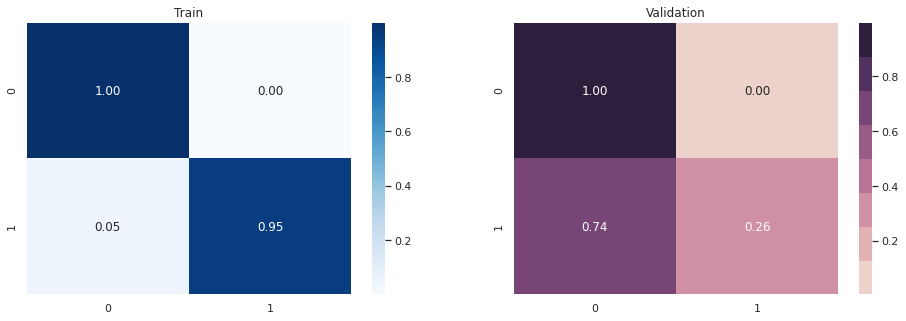

Fold: 2


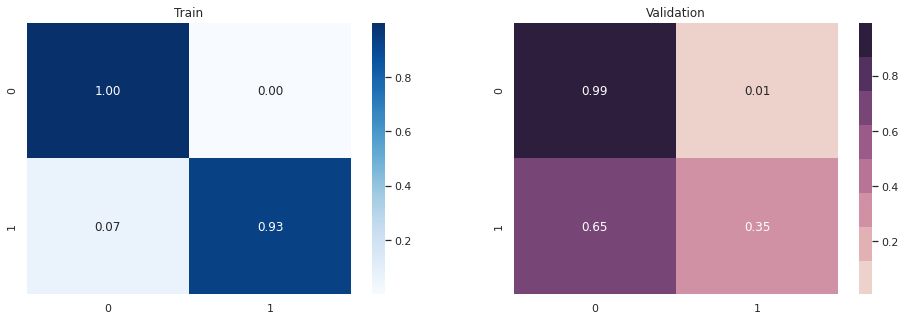

Fold: 3


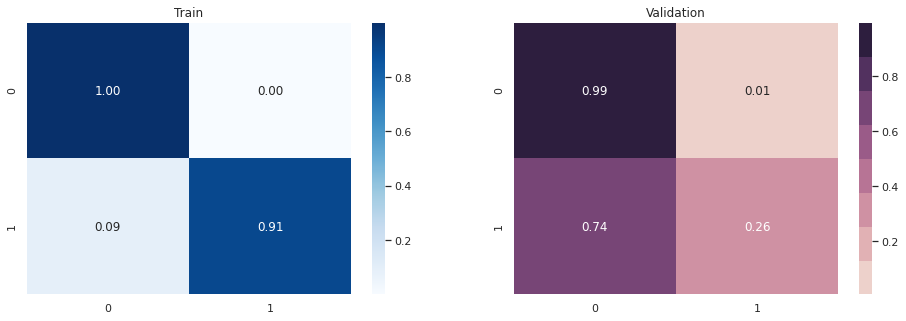

In [43]:
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [44]:
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")

Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.013622,0.019537,0.024400,0.024175
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.015810,0.024935,0.023355,0.030759
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.014715,0.023088,0.020802,0.029684
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.013488,0.027939,0.020485,0.019014
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.015365,0.025599,0.025402,0.025822
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.014357,0.020190,0.027811,0.023785
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.013733,0.019011,0.025787,0.023867
7,ISIC_0075663,female,35.0,torso,unknown,0,0.013264,0.022919,0.021031,0.022371
8,ISIC_0075914,male,30.0,torso,unknown,0,0.017482,0.032040,0.030026,0.025343
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.021156,0.048915,0.031881,0.024984


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.210195,0.025592,0.974723,0.050660
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.388910,0.946349,0.022221,0.975979
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.209989,0.928028,0.017182,0.104733
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.591139,0.976157,0.995215,0.984322
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.564901,0.973658,0.959672,0.891177
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.592472,0.981402,0.987206,0.993753
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.400127,0.969590,0.960907,0.070140
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.573709,0.952907,0.951393,0.964247
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.331689,0.069016,0.979386,0.610042
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.213024,0.977382,0.045988,0.041751


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.591139,0.976157,0.995215,0.984322
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.564901,0.973658,0.959672,0.891177
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.592472,0.981402,0.987206,0.993753
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.573709,0.952907,0.951393,0.964247
607,ISIC_0286360,male,60.0,upper extremity,melanoma,1,0.572305,0.981384,0.980647,0.899496
747,ISIC_0327406,male,40.0,upper extremity,melanoma,1,0.589403,0.990787,0.966884,0.989345
758,ISIC_0333091,male,25.0,lower extremity,melanoma,1,0.588255,0.974337,0.978445,0.988491
826,ISIC_0351666,male,80.0,head/neck,melanoma,1,0.520132,0.949955,0.676851,0.973855
886,ISIC_0369831,male,80.0,upper extremity,melanoma,1,0.590826,0.977956,0.987226,0.988947
1332,ISIC_0502582,male,65.0,lower extremity,melanoma,1,0.576986,0.944772,0.977934,0.962226


Label/prediction distribution
Train positive labels: 584
Train positive predictions: 297
Train positive correct predictions: 297


# Make predictions (best)

In [45]:
model_path_list = glob.glob(MODEL_BASE_PATH + 'model' + '*.h5')
n_models = len(model_path_list)
model_path_list.sort()

print(f'{n_models} Models to predict:')
print(*model_path_list, sep='\n')

3 Models to predict:
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/38-resnet152/model_fold_1.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/38-resnet152/model_fold_2.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/38-resnet152/model_fold_3.h5


In [46]:
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))


for model_path in model_path_list:
    K.clear_session()
    print(model_path)
    model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
    model.load_weights(model_path)
    
    test_preds += model.predict(test_dataset) / n_models


image_names = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
name_preds = dict(zip(image_names, test_preds.reshape(len(test_preds))))
test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)

/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/38-resnet152/model_fold_1.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/38-resnet152/model_fold_2.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/38-resnet152/model_fold_3.h5


# Make predictions (last)

In [47]:
model_path_list = glob.glob(MODEL_BASE_PATH + 'last' + '*.h5')
n_models = len(model_path_list)
model_path_list.sort()

print(f'{n_models} Models to predict:')
print(*model_path_list, sep='\n')

3 Models to predict:
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/38-resnet152/last_model_fold_1.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/38-resnet152/last_model_fold_2.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/38-resnet152/last_model_fold_3.h5


In [48]:
test_preds = np.zeros((NUM_TEST_IMAGES, 1))


for model_path in model_path_list:
    K.clear_session()
    print(model_path)
    model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
    model.load_weights(model_path)
    
    test_preds += model.predict(test_dataset) / n_models


name_preds = dict(zip(image_names, test_preds.reshape(len(test_preds))))
test['target_last'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)

/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/38-resnet152/last_model_fold_1.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/38-resnet152/last_model_fold_2.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/38-resnet152/last_model_fold_3.h5


# Visualize test predictions

In [49]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")
print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 127|10855
Test predictions (last) 140|10842
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
0,ISIC_0052060,male,70.0,NaN,0.025890,0.024119
1,ISIC_0052349,male,40.0,lower extremity,0.029483,0.027682
2,ISIC_0058510,female,55.0,torso,0.026086,0.024664
3,ISIC_0073313,female,50.0,torso,0.026814,0.024674
4,ISIC_0073502,female,45.0,lower extremity,0.028187,0.025717
5,ISIC_0074618,male,50.0,lower extremity,0.037823,0.033045
6,ISIC_0076801,male,45.0,upper extremity,0.024858,0.022930
7,ISIC_0077586,male,50.0,lower extremity,0.025198,0.023243
8,ISIC_0082004,female,45.0,torso,0.023991,0.022424
9,ISIC_0082785,male,65.0,lower extremity,0.027257,0.025283


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
24,ISIC_0112420,female,65.0,torso,0.938324,0.932010
102,ISIC_0208233,female,60.0,lower extremity,0.900190,0.931624
296,ISIC_0391046,male,85.0,torso,0.900439,0.875422
403,ISIC_0481105,male,80.0,torso,0.969937,0.971853
471,ISIC_0539432,female,45.0,lower extremity,0.895982,0.902915
530,ISIC_0588352,male,60.0,lower extremity,0.680388,0.646780
552,ISIC_0606244,male,70.0,torso,0.867800,0.893907
596,ISIC_0637104,female,80.0,torso,0.504305,0.549157
764,ISIC_0775584,female,35.0,lower extremity,0.572696,0.500101
1069,ISIC_1030252,female,50.0,head/neck,0.630338,0.676988


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
24,ISIC_0112420,female,65.0,torso,0.938324,0.932010
102,ISIC_0208233,female,60.0,lower extremity,0.900190,0.931624
296,ISIC_0391046,male,85.0,torso,0.900439,0.875422
403,ISIC_0481105,male,80.0,torso,0.969937,0.971853
471,ISIC_0539432,female,45.0,lower extremity,0.895982,0.902915
530,ISIC_0588352,male,60.0,lower extremity,0.680388,0.646780
552,ISIC_0606244,male,70.0,torso,0.867800,0.893907
596,ISIC_0637104,female,80.0,torso,0.504305,0.549157
764,ISIC_0775584,female,35.0,lower extremity,0.572696,0.500101
1069,ISIC_1030252,female,50.0,head/neck,0.630338,0.676988


# Test set predictions (best)

In [50]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission.to_csv(SUBMISSION_PATH, index=False)
display(submission.head(10))
display(submission.describe())

,image_name,target
0,ISIC_0052060,0.025890
1,ISIC_0052349,0.029483
2,ISIC_0058510,0.026086
3,ISIC_0073313,0.026814
4,ISIC_0073502,0.028187
5,ISIC_0074618,0.037823
6,ISIC_0076801,0.024858
7,ISIC_0077586,0.025198
8,ISIC_0082004,0.023991
9,ISIC_0082785,0.027257


,target
count,10982.000000
mean,0.043294
std,0.089191
min,0.016105
25%,0.025065
50%,0.026682
75%,0.029014
max,0.989713


# Test set predictions (last)

In [51]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target_last']
submission.to_csv(SUBMISSION_LAST_PATH, index=False)
display(submission.head(10))
display(submission.describe())

,image_name,target
0,ISIC_0052060,0.024119
1,ISIC_0052349,0.027682
2,ISIC_0058510,0.024664
3,ISIC_0073313,0.024674
4,ISIC_0073502,0.025717
5,ISIC_0074618,0.033045
6,ISIC_0076801,0.022930
7,ISIC_0077586,0.023243
8,ISIC_0082004,0.022424
9,ISIC_0082785,0.025283


,target
count,10982.000000
mean,0.042291
std,0.091982
min,0.015003
25%,0.023347
50%,0.024887
75%,0.027147
max,0.990168
